# Texas Annual Air Quality Index (AQI) Visualizer Project (2014-2023)

### Ayan Sarkar

### May 2024

### Import Relevant Libraries

In [8]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import glob
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sns

### Background

![AQI Image](aqi.png)

My analysis below looks at air quality in the state of Texas over the past decade. The Texas Commission on Environmental Quality (TCEQ) monitors ambient air concentrations of Criteria 6 pollutants and other compounds at stationary monitoring sites across the state. My code aims to provide a simple user-oriented interface within Jupyter to view chloropleths of Max AQI values for any year between 2014 & 2023 as measured by monitors in specific counties to capture the severity of pollution over time and across space.

The TCEQ writes, "Placement of air monitors is determined consistent with federal air monitoring rules using population trends, reported emissions inventory data, local meteorological data, and, if available, existing air monitoring data for a given area". I have included the Air Monitor locations below as geopoints as well for reference. 

The National Ambient Air Quality Standards (NAAQS) established with the passage of the 1990 Clean Air Amendment (CAA) designated specific areas as 'Attainment' or 'Nonattainment' based on whether or not they meet the national primary or secondary ambient air quality standards for certain pollutants (EPA). Here, I plot general AQI, which is a uniform composite index based off 24-hour or 8-hour concentration readings of multiple pollutants.

### Read in AQI Monitor Data

In [13]:
# Read in the shapefile containing just the outline of the state
state_outline = gpd.read_file("State.shp")
#Read in EPA AQI Data
csv_files = glob.glob(os.path.join(os.getcwd(), "annual_aqi_by_county_*.csv"))

# Read each CSV file and create individual DataFrames
for file in csv_files:
    # Extract the year from the file name
    year = os.path.basename(file)[-8:-4]
    # Construct the DataFrame name
    df_name = f"AQI_{year}"
    # Read the CSV file into a DataFrame
    globals()[df_name] = pd.read_csv(file)
monitors = pd.read_csv('annual_conc_by_monitor_2023.csv')
monitors = monitors.rename(columns={'County Name': 'County'})


## Visualize Annual Texas AQI 

Enter the Desired Year of AQI Data (2014-2023): 2020


/Users/ayansarkar/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/9t/zsl748y93k95tp4c5122vtxw0000gn/T/ipykernel_95833/2852586436.py:54: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  monitors_within_texas = gpd.sjoin(monitors_gdf, gdf, how='inner', op='within')
/var/folders/9t/zsl748y93k95tp4c5122vtxw0000gn/T/ipykernel_95833/2852586436.py:75: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or 

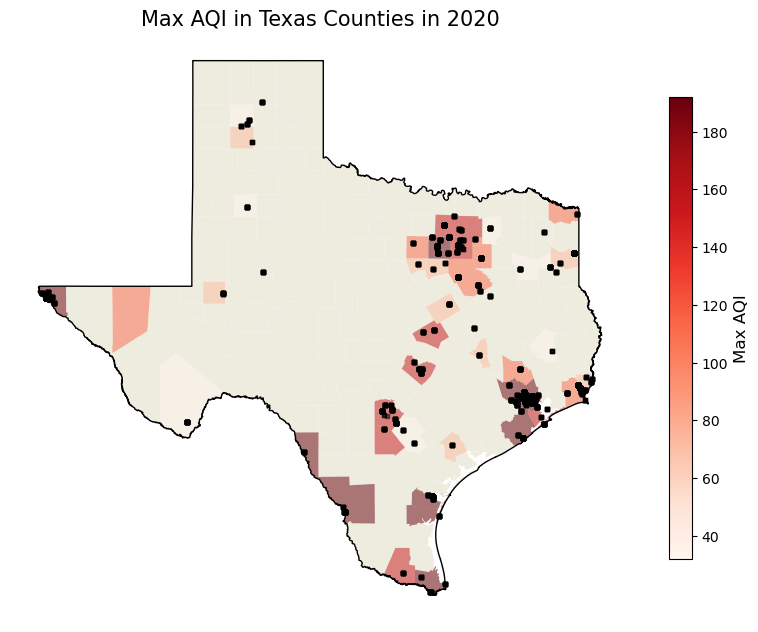

In [14]:
# Create an empty dictionary to store dataframes
dataframes = {}

# Use glob to find all CSV files that match the pattern
csv_files = glob.glob(os.path.join(os.getcwd(), "annual_aqi_by_county_*.csv"))

# Read each CSV file and store it in the dictionary
for file in csv_files:
    # Extract the year from the file name
    year = os.path.basename(file)[-8:-4]
    # Construct the DataFrame name
    df_name = f"AQI_{year}"
    # Read the CSV file into a DataFrame
    dataframes[df_name] = pd.read_csv(file)

# Function to get a DataFrame by its constructed name
def get_dataframe_by_name(df_name):
    if df_name in dataframes:
        return dataframes[df_name]
    else:
        print(f"No DataFrame found with the name '{df_name}'.")
        return None

user_input = input("Enter the Desired Year of AQI Data (2014-2023): ")
df_name = f"AQI_{user_input}"

# Get the DataFrame by its name
df = get_dataframe_by_name(df_name)

def filter_and_drop(df):
    """
    Function to filter rows for 'Texas' in the 'State' column
    and drop the 'Year' column.
    """
    return df[df['State'] == 'Texas'].drop(columns='Year')

df = filter_and_drop(df)

shapefile_path = "Tx_CntyBndry_Detail_TIGER500k.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)
gdf['NAME'] = gdf['NAME'].str.replace(' County', '')

# Rename 'County' to enable merge
gdf = gdf.rename(columns={'NAME': 'County'})
dff = gdf.merge(df, on='County')

# Make sure 'monitors' is defined before using it in the merge
state_outline = state_outline.to_crs(gdf.crs)

# Perform the spatial join to filter only monitors within the Texas boundary
monitors_gdf = gpd.GeoDataFrame(monitors, geometry=gpd.points_from_xy(monitors.Longitude, monitors.Latitude))
monitors_within_texas = gpd.sjoin(monitors_gdf, gdf, how='inner', op='within')

# Plot the counties with invisible lines for clarity & aesthetics
ax = gdf.plot(color='#EEECDF', edgecolor='none', figsize=(10, 10))

# Plot 'Max AQI' values from dff
dff.plot(column='Max AQI', ax=ax, legend=False, cmap='Reds', scheme='quantiles', alpha=0.5, edgecolor='none')
# Overlay the state outline on top of the counties plot
state_outline.plot(ax=ax, color='none', edgecolor='black')

# Plot only monitoring stations within Texas
ax.scatter(monitors_within_texas.geometry.x, monitors_within_texas.geometry.y, 
           marker='s', color='k', alpha=0.5, s=10, label='Monitoring Stations')

# Set plot title 
plt.title('Max AQI in Texas Counties in ' + str(user_input), fontsize=15)

# Add a colorbar gradient legend
norm = mcolors.Normalize(vmin=dff['Max AQI'].min(), vmax=dff['Max AQI'].max())
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.6)  # Adjust the shrink parameter as needed
cbar.set_label('Max AQI', fontsize=12)

# Turn off the axis grid
ax.axis('off')

# Show plot
plt.show()


It is also interesting to note in the map above, that while the Permian Basin is home to some of the heaviest polluting industry in the state, you may notice that there are only 3 monitors in the entire region. This is due to strong industry pushback against proposals to issue an ozone nonattainment designation, which would have required that companies reduce oilfield emissions (Texas Tribune). 

The changes in AQI over the years may be subtle, but illustrate how different counties evolve over time in ther pollution levels.

### View Annual Air Monitor Data by County

In [257]:
# Create a dropdown widget with all counties
county_dropdown = widgets.Dropdown(
    options=dff['County'].unique(),
    description='Select County:'
)

# Define a function to handle dropdown value changes
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_county = change['new']
        # Clear previous output
        clear_output(wait=True)
        # Filter the DataFrame based on the selected county
        county_data = dff[dff['County'] == selected_county]
        # Print the associated row for selected county
        display(county_data[['Days with AQI',
                           'Good Days',
                           'Moderate Days',
                           'Unhealthy for Sensitive Groups Days',
                           'Unhealthy Days',
                           'Very Unhealthy Days',
                           'Hazardous Days',
                           'Max AQI',
                           '90th Percentile AQI',
                           'Median AQI',
                           'Days CO',
                           'Days NO2',
                           'Days Ozone',
                           'Days PM2.5',
                           'Days PM10']])
        

# Attach the function to dropdown's selection
county_dropdown.observe(on_change)

# Display the dropdown widget
display(county_dropdown)

,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
5,366,307,59,0,0,0,0,93,57,37,0,0,265,101,0


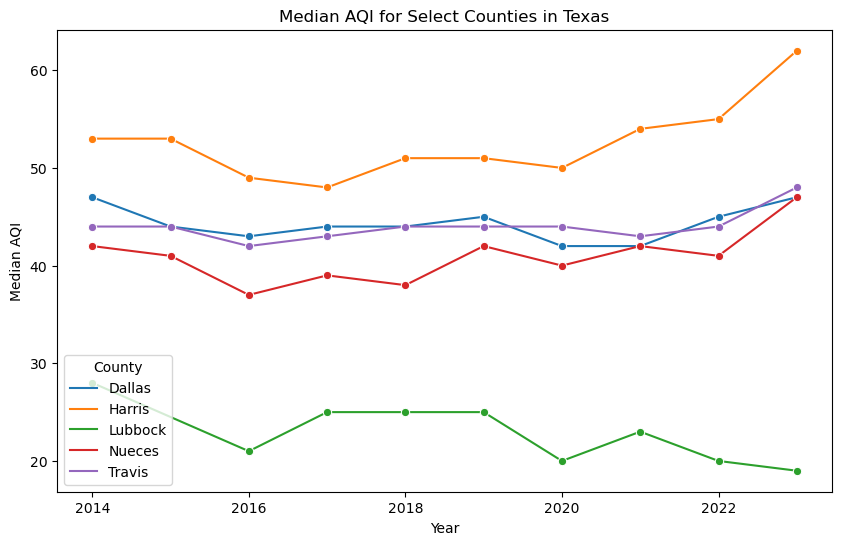

In [248]:
#Set Figure Plot
plt.figure(figsize=(10, 6))
# Concatenate the DataFrames
aqi_concatenated = pd.concat([AQI_2014, AQI_2015, AQI_2016, AQI_2017, AQI_2018, AQI_2019, AQI_2020, AQI_2021, AQI_2022, AQI_2023])

# Filter for State == 'Texas'
aqi_texas = aqi_concatenated[aqi_concatenated['State'] == 'Texas']

# Filter for counties 'Travis', 'Harris', and 'Dallas'
counties_of_interest = ['Travis', 'Harris', 'Dallas', 'Nueces', 'Lubbock']
aqi_counties = aqi_texas[aqi_texas['County'].isin(counties_of_interest)]

# Plot 'Median AQI' for the selected counties with different colors
sns.lineplot(data=aqi_counties, x='Year', y='Median AQI', hue='County', marker='o', linestyle='-')

# Set plot title and labels
plt.title('Median AQI for Select Counties in Texas')
plt.xlabel('Year')
plt.ylabel('Median AQI')

# Show plot
plt.show()


### Works Cited

U.S. Environmental Protection Agency. "Air Data Home." U.S. Environmental Protection Agency, https://www.epa.gov/outdoor-air-quality-data. Accessed 17 May 2024.


Simple Widget Introduction. "Simple Widget Introduction - Jupyter Widgets 8.1.2 Documentation", ipywidgets, ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html. Accessed 17 May 2024.  

“Air Quality Index.” American Lung Association, www.lung.org/clean-air/outdoors/air-quality-index. Accessed 17 May 2024. 